**context:** German Mills Settlers Park

![flux_estimates_table.png](ipynb_img/flux_estimates_table.png)

**goal:** assess pressure changes over period of time before/during/after measurement to see if different fluxes can be explained

**reference paper:** https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013GB004571 (see figure 4)

![pressure_profile_fig_from_paper.png](ipynb_img/pressure_profile_fig_from_paper.png)

*pressure data sourced from Buttonville Airport:* https://climate.weather.gc.ca/historical_data/search_historic_data_e.html
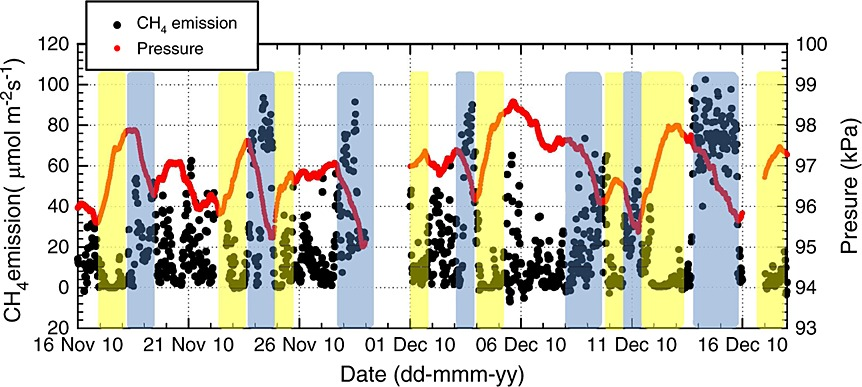
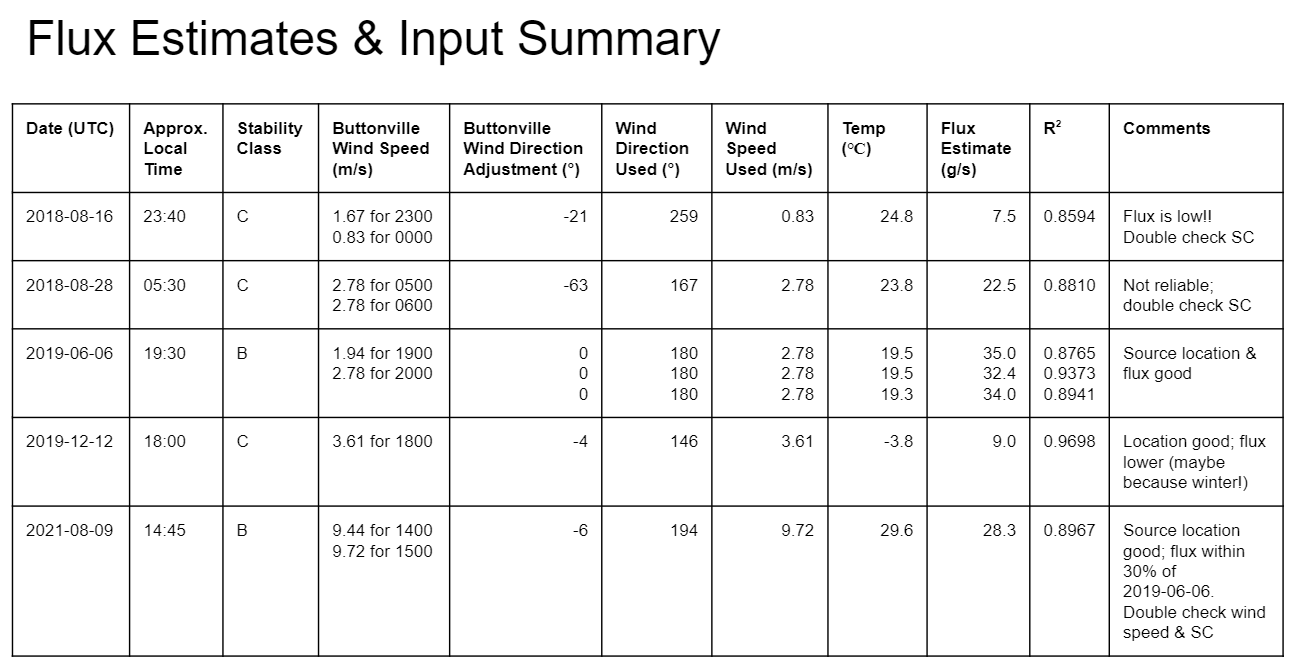

In [1]:
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from matplotlib.dates import date2num
from statistics import mean

In [4]:
def convert_to_time_hms(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

def convert_to_time_hm(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M")

In [8]:
root_path = os.path.dirname(os.path.dirname(os.getcwd()))
transect_path = os.path.join(root_path, "src", "polyphemus_prep", "german_mills_transects")
buttonville_path = os.path.join(root_path, "data", "airport_data", "buttonville")
pressure_profiles_save_path = os.path.join(root_path, "outputs", "fig", "pressure_profiles")

In [11]:
transect_files = os.listdir(transect_path)

transect_entry_exit_times = {}
for i in range(len(transect_files)):
    if transect_files[i][-4:] != ".txt":
        df_transect = pd.read_csv(os.path.join(transect_path, transect_files[i]))
        df_transect["gps_time"] = df_transect["gps_time"].apply(convert_to_time_hms)
        df_transect.set_index("gps_time", inplace=True)
        times = {"entry": df_transect.index[0], "exit": df_transect.index[-1]}
        transect_entry_exit_times[transect_files[i][22:-4]] = times

print(transect_entry_exit_times)

{'2018-08-16': {'entry': Timestamp('2018-08-16 03:38:00'), 'exit': Timestamp('2018-08-16 03:41:30')}, '2018-08-28': {'entry': Timestamp('2018-08-28 09:31:01'), 'exit': Timestamp('2018-08-28 09:32:48')}, '2019-06-06_1': {'entry': Timestamp('2019-06-06 23:32:54'), 'exit': Timestamp('2019-06-06 23:34:48')}, '2019-06-06_2': {'entry': Timestamp('2019-06-06 23:39:03'), 'exit': Timestamp('2019-06-06 23:40:53')}, '2019-06-06_3': {'entry': Timestamp('2019-06-06 23:42:19'), 'exit': Timestamp('2019-06-06 23:44:29')}, '2019-12-12': {'entry': Timestamp('2019-12-12 23:00:10'), 'exit': Timestamp('2019-12-12 23:01:41')}, '2021-08-09_1': {'entry': Timestamp('2021-08-09 18:23:31'), 'exit': Timestamp('2021-08-09 18:25:14')}, '2021-08-09_2': {'entry': Timestamp('2021-08-09 18:44:53'), 'exit': Timestamp('2021-08-09 18:46:24')}}


In [12]:
drive_entry_exit_times = {}
transect_labels = list(transect_entry_exit_times.keys())
for i in range(len(transect_labels)):
    if len(transect_labels[i]) == 10:
        drive_entry_exit_times[transect_labels[i]] = transect_entry_exit_times[transect_labels[i]]
    else:
        if transect_labels[i][-1] == '1':
            drive_entry_exit_times[transect_labels[i][:-2]] = {"entry": transect_entry_exit_times[transect_labels[i]]["entry"]}
        else:
            drive_entry_exit_times[transect_labels[i][:-2]]["exit"] = transect_entry_exit_times[transect_labels[i]]["exit"]

print(drive_entry_exit_times)

{'2018-08-16': {'entry': Timestamp('2018-08-16 03:38:00'), 'exit': Timestamp('2018-08-16 03:41:30')}, '2018-08-28': {'entry': Timestamp('2018-08-28 09:31:01'), 'exit': Timestamp('2018-08-28 09:32:48')}, '2019-06-06': {'entry': Timestamp('2019-06-06 23:32:54'), 'exit': Timestamp('2019-06-06 23:44:29')}, '2019-12-12': {'entry': Timestamp('2019-12-12 23:00:10'), 'exit': Timestamp('2019-12-12 23:01:41')}, '2021-08-09': {'entry': Timestamp('2021-08-09 18:23:31'), 'exit': Timestamp('2021-08-09 18:46:24')}}


~~~~ 2018-08-16 ~~~~
hourly rate of change over 3h:	0.317 hPa/h
hourly rate of change over 6h:	0.44 hPa/h


~~~~ 2018-08-28 ~~~~
hourly rate of change over 3h:	-0.2307 hPa/h
hourly rate of change over 6h:	-0.0683 hPa/h


~~~~ 2019-06-06 ~~~~
hourly rate of change over 3h:	-0.0183 hPa/h
hourly rate of change over 6h:	-0.0533 hPa/h


~~~~ 2019-12-12 ~~~~
hourly rate of change over 3h:	-0.7713 hPa/h
hourly rate of change over 6h:	-0.869 hPa/h


~~~~ 2021-08-09 ~~~~
hourly rate of change over 3h:	-0.206 hPa/h
hourly rate of change over 6h:	-0.17 hPa/h




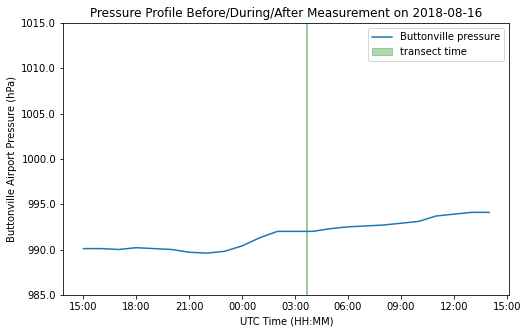

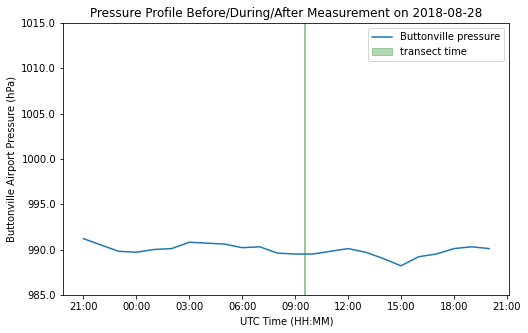

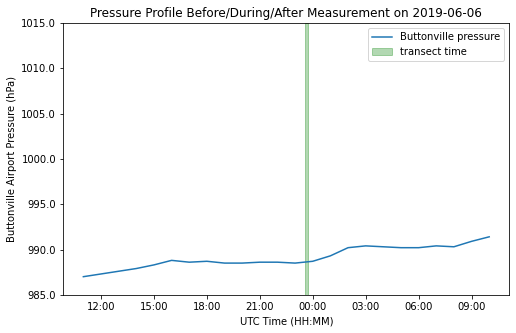

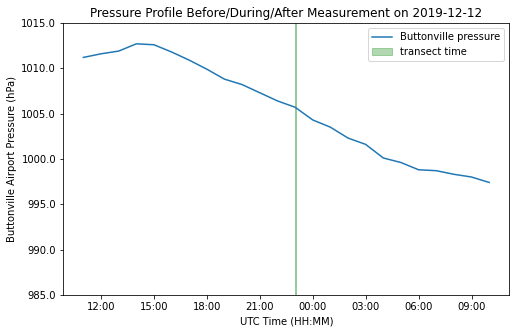

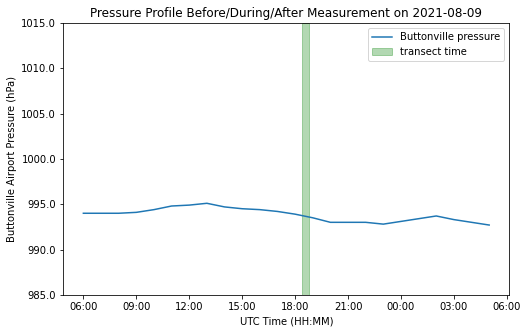

In [17]:
dates = list(drive_entry_exit_times.keys())

for i in range(len(dates)):

    buttonville_start_time = drive_entry_exit_times[dates[i]]["entry"] - timedelta(hours=12)
    buttonville_start_time = buttonville_start_time.replace(minute=0, second=0)
#     print(buttonville_start_time)

    year = dates[i][:4]
    month = dates[i][5:7]
    day = dates[i][8:]
    buttonville_filename = "en_climate_hourly_ON_6158409_" + month + "-" + year + "_P1H.csv"
    df_buttonville = pd.read_csv(os.path.join(buttonville_path, buttonville_filename))
    df_buttonville["Date/Time (UTC)"] = df_buttonville["Date/Time (UTC)"].apply(convert_to_time_hm)

    buttonville_start_index = 0
    while (df_buttonville.loc[buttonville_start_index, "Date/Time (UTC)"] < buttonville_start_time):
        buttonville_start_index += 1
    buttonville_end_index = buttonville_start_index + 23    # assuming not end of month

    hourly_time = df_buttonville.loc[buttonville_start_index:buttonville_end_index, "Date/Time (UTC)"]
    pressure_kpa = df_buttonville.loc[buttonville_start_index:buttonville_end_index, "Stn Press (kPa)"]
    pressure_hpa = pressure_kpa * 10
#     print(hourly_time)
#     print(pressure_hpa)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(hourly_time, pressure_hpa, label="Buttonville pressure")
    ax.axvspan(date2num(drive_entry_exit_times[dates[i]]["entry"]), date2num(drive_entry_exit_times[dates[i]]["exit"]), 
               label="transect time", color="green", alpha=0.3)

    # weighted avg assuming airport data points are at end of interval
    avg_period = [3, 6]
    weighted_avg_change = []
    transect_exit_time = drive_entry_exit_times[dates[i]]["exit"]
    for j in range(len(avg_period)):
        weighted_pressure_change_hpa = []
        for k in range(len(pressure_hpa)):
            if hourly_time.iloc[k].hour < transect_exit_time.hour - avg_period[j]:
                weight = 0
            elif hourly_time.iloc[k].hour > transect_exit_time.hour + 1:
                weight = 0
            elif hourly_time.iloc[k].hour == transect_exit_time.hour - (avg_period[j] - 1):
                weight = 1 - transect_exit_time.minute / 60
            elif hourly_time.iloc[k].hour == transect_exit_time.hour + 1:
                weight = transect_exit_time.minute / 60
            else:
                weight = 1
            pressure_change_over_hour = pressure_hpa.iloc[k] - pressure_hpa.iloc[k-1]
            if weight != 0:
                weighted_pressure_change_hpa.append(pressure_change_over_hour * weight)
#         print(weighted_pressure_change_hpa)
        weighted_avg_change.append(round(mean(weighted_pressure_change_hpa), 4))
    print("~~~~ " + dates[i] + " ~~~~")
    print("hourly rate of change over " + str(avg_period[0]) + "h:\t" + str(weighted_avg_change[0]) + " hPa/h")
    print("hourly rate of change over " + str(avg_period[1]) + "h:\t" + str(weighted_avg_change[1]) + " hPa/h")
    print("\n")

    plt.ylim([985, 1015])
    ax_format = plt.gca()
    ax_format.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    ax_format.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    plt.title("Pressure Profile Before/During/After Measurement on " + dates[i])
    plt.xlabel("UTC Time (HH:MM)")
    plt.ylabel("Buttonville Airport Pressure (hPa)")
    plt.legend()
    # plt.savefig(os.path.join(pressure_profiles_save_path, "pressure_profile_during_" + dates[i] + "_measurement.png"), facecolor="white")
    # plt.close()